ICR - Identify Age_Related Conditions
=====================================

[Kaggle Competition](https://www.kaggle.com/competitions/icr-identify-age-related-conditions)

icr_notebook_290623
Based on: [gusthema/identifying-age-related-conditions-w-tfdf](https://www.kaggle.com/code/gusthema/identifying-age-related-conditions-w-tfdf)

In [8]:
# Install packages if they not installed already, otherwise don;t waste time
import pkg_resources

def install(package):
    try:
        pkg_resources.get_distribution(package)
        print("{} ({}) is already installed".format(package, pkg_resources.get_distribution(package).version))
    except pkg_resources.DistributionNotFound:
        print("{} is NOT installed. Installing it.".format(package))
        %pip install {package}

install('scikit-learn')
install('tensorflow')
install('tensorflow_decision_forests')

scikit-learn (1.2.2) is already installed
tensorflow (2.12.0) is already installed
tensorflow_decision_forests (1.3.0) is already installed


In [9]:
import math

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Data Exploration

In [10]:
# read in data
input_df = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/train.csv')
test_df = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/test.csv')
sample_submission = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv')
greeks = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/greeks.csv')

# df = pd.read_csv('../data/train.csv')
input_df.head()

Id        AB          AF          AH         AM        AR   
0  000ff2bfdfe9  0.209377  3109.03329   85.200147  22.394407  8.138688  \
1  007255e47698  0.145282   978.76416   85.200147  36.968889  8.138688   
2  013f2bd269f5  0.470030  2635.10654   85.200147  32.360553  8.138688   
3  043ac50845d5  0.252107  3819.65177  120.201618  77.112203  8.138688   
4  044fb8a146ec  0.380297  3733.04844   85.200147  14.103738  8.138688   

         AX        AY         AZ          BC  ...        FL        FR   
0  0.699861  0.025578   9.812214    5.555634  ...  7.298162   1.73855  \
1  3.632190  0.025578  13.517790    1.229900  ...  0.173229   0.49706   
2  6.732840  0.025578  12.824570    1.229900  ...  7.709560   0.97556   
3  3.685344  0.025578  11.053708    1.229900  ...  6.122162   0.49706   
4  3.942255  0.054810   3.396778  102.151980  ...  8.153058  48.50134   

         FS         GB          GE            GF         GH         GI   
0  0.094822  11.339138   72.611063   2003.810319  22.136229  69.834944  \
1  0.568932   9.292698   72.611063  27981.562750  29.135430  32.131996   
2  1.198821  37.077772   88.609437  13676.957810  28.022851  35.192676   
3  0.284466  18.529584   82.416803   2094.262452  39.948656  90.493248   
4  0.121914  16.408728  146.109943   8524.370502  45.381316  36.262628   

          GL  Class  
0   0.120343      1  
1  21.978000      0  
2   0.196941      0  
3   0.155829      0  
4   0.096614      1  

[5 rows x 58 columns]

In [11]:
# All stats placeholder
stats_df = pd.DataFrame(columns=["Column", "Min", "1st Q", "Median", "Mean", "3rd Q", "Max"])

# get the features columns
features_cols = input_df.select_dtypes(include=[np.number]).columns[1:-1]

# create a subplot grid
cols = 1
rows = math.ceil(len(features_cols) / cols)
fig, axes = plt.subplots(rows, cols, figsize=(20, 5 * rows))  # adjust the size as needed

# flatten axes for easy iteration
axes = axes.flatten()

for i, col in enumerate(features_cols):
    if input_df[col].isna().any():
        input_sr = input_df[col].dropna()
        col_name = f"{col} (NaN dropped)"
    else:
        input_sr = input_df[col]
        col_name = f"{col}"

    min = input_sr.min()
    mean = input_sr.mean()
    median = input_sr.median()
    q1 = input_sr.quantile(0.25)
    q3 = input_sr.quantile(0.75)
    max = input_sr.max()

    stats_df.loc[i] = [col_name, min, q1, median, mean, q3, max]

    # Plot with histplot and kde
    ax = axes[i]
    sns.histplot(input_sr, kde=True, ax=ax)

    # Replace all `plt.` with `ax.`
    ax.text(0.5, 0.9, col_name, size=40, ha='center', va='center', transform=ax.transAxes)

    ax.axvline(mean, color='red', linestyle='--')
    ax.axvline(median, color='green', linestyle='--')
    ax.axvline(q1, color='yellow', linestyle='--')
    ax.axvline(q3, color='yellow', linestyle='--')

    # Annotations
    y = ax.get_ylim()[1]
    offset = y * 0.13  # 5% of the y-axis range
    ax.text(mean, y-offset, 'Mean', rotation=90, color='red')
    ax.text(median, y-offset, 'Median', rotation=90, color='green')
    ax.text(q1, y-offset, '1st Q', rotation=90, color='yellow')
    ax.text(q3, y-offset, '3rd Q', rotation=90, color='yellow')
    
    # Add horizontal line at max count and label it
    hist, bins = np.histogram(input_sr, bins='auto')
    max_count = hist.max()
    ax.axhline(max_count, color='blue', linestyle='-')
    ax.text(ax.get_xlim()[1]/2, max_count - offset, f'Max Count: {max_count}', ha='center', color='blue')

    # Show table with stats inside the plot
    stats = f'''
            Min: {min:.2f}
            1st Q: {q1:.2f}
            Median: {median:.2f}
            Mean: {mean:.2f}
            3rd Q: {q3:.2f}
            Max: {max:.2f}
    '''
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.75, 0.95, stats, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

# remove unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

print(stats_df.to_string())

plt.tight_layout()
plt.show()

              Column          Min        1st Q       Median          Mean         3rd Q            Max
0                 AF   192.593280  2197.345480  3120.318960   3502.013221   4361.637390   28688.187660
1                 AH    85.200147    85.200147    85.200147    118.624513    113.739540    1910.123198
2                 AM     3.177522    12.270314    20.533110     38.968552     39.139886     630.518230
3                 AR     8.138688     8.138688     8.138688     10.128242      8.138688     178.943634
4                 AX     0.699861     4.128294     5.031912      5.545576      6.431634      38.270880
5                 AY     0.025578     0.025578     0.025578      0.060320      0.036845      10.315851
6                 AZ     3.396778     8.129580    10.461320     10.566447     12.969516      38.971568
7                 BC     1.229900     1.229900     1.229900      8.053012      5.081244    1463.693448
8                BD   1693.624320  4155.702870  4997.960730   5350.388655

### Correlation coefficient

In [12]:
for column in input_df.columns:
    print(f"Column: {column}")
    dtype = input_df[column].dtypes

    # Check if data type is object or if there are any NaN values
    if dtype == 'object' or input_df[column].isnull().any():
        print(f"Column: {column}, Type: {dtype}")
        print(f"First 5 values:\n{input_df[column].head()}")
        print(f"Number of NaN values: {input_df[column].isnull().sum()}")
        print(f"Summary:\n{input_df[column].describe()}\n")
        input_df[column].fillna(0, inplace=True)

input_df.drop(columns="EJ", inplace=True)

Column: Id
Column: Id, Type: object
First 5 values:
0    000ff2bfdfe9
1    007255e47698
2    013f2bd269f5
3    043ac50845d5
4    044fb8a146ec
Name: Id, dtype: object
Number of NaN values: 0
Summary:
count              617
unique             617
top       000ff2bfdfe9
freq                 1
Name: Id, dtype: object

Column: AB
Column: AF
Column: AH
Column: AM
Column: AR
Column: AX
Column: AY
Column: AZ
Column: BC
Column: BD 
Column: BN
Column: BP
Column: BQ
Column: BQ, Type: float64
First 5 values:
0    152.707705
1     14.754720
2    219.320160
3     11.050410
4    149.717165
Name: BQ, dtype: float64
Number of NaN values: 60
Summary:
count    557.000000
mean      98.328737
std       96.479371
min        1.331155
25%       27.834425
50%       61.642115
75%      134.009015
max      344.644105
Name: BQ, dtype: float64

Column: BR
Column: BZ
Column: CB
Column: CB, Type: float64
First 5 values:
0    47.223358
1    30.284345
2    32.563713
3    15.201914
4    82.213495
Name: CB, dtype: float6

[('AB', 0.2806118820146081), ('AF', 0.30263845295706254), ('AH', 0.04464546313759181), ('AM', 0.23916993156241662), ('AR', 0.06438034287892723), ('AX', 0.09761578296404438), ('AY', 0.08242036653398226), ('AZ', 0.013515606981951138), ('BC', 0.1558815349542324), ('BD ', 0.11218407269891827), ('BN', 0.19828288876105485), ('BP', 0.15728644290909433), ('BQ', 0.3107711962955039), ('BR', 0.08855356255112842), ('BZ', 0.11242330489019955), ('CB', -0.014041429758815824), ('CC', -0.05882944671098605), ('CD ', 0.17130354932075312), ('CF', 0.1097477461204545), ('CH', 0.008144308808507071), ('CL', 0.016852143236700586), ('CR', -0.22754659276787195), ('CS', -0.04743807484657199), ('CU', -0.08318486460783603), ('CW ', -0.0626391112147136), ('DA', -0.2046120370858707), ('DE', -0.12497729147482405), ('DF', 0.06427208885747945), ('DH', -0.2068392454005764), ('DI', 0.26075980571986845), ('DL', -0.14771602038439668), ('DN', -0.008477749950987788), ('DU', 0.2610962640359574), ('DV', 0.015477478340990392), (

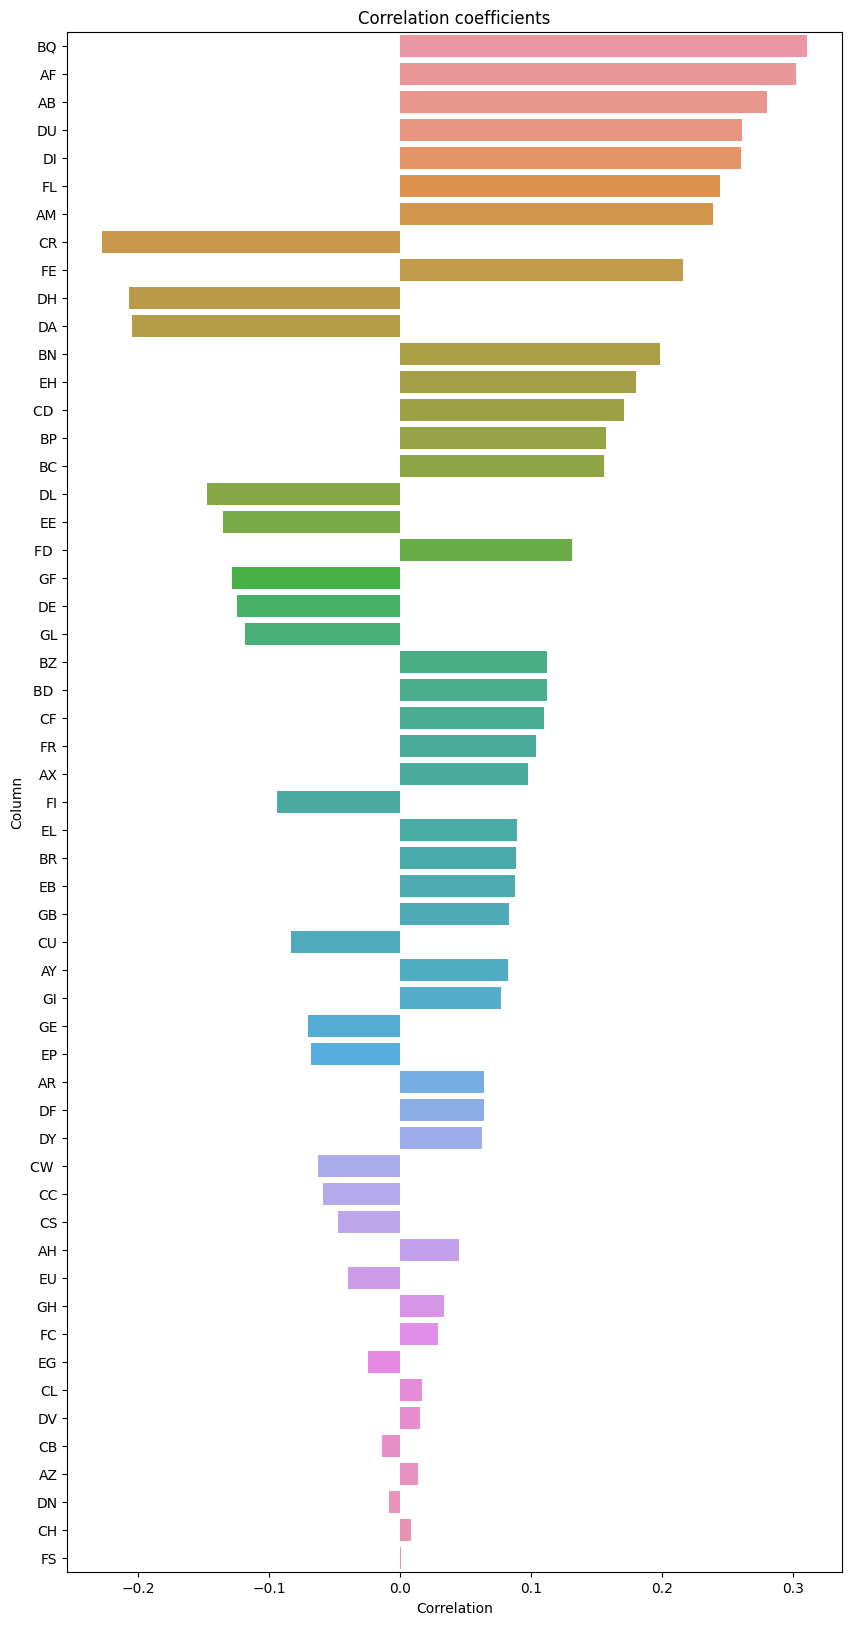

In [13]:
corr_coeffs = []
for column in input_df.columns:
    if column not in ["Id", "Class"]:
        corr_coeffs.append(
            (
              column,
              np.corrcoef(input_df["Class"], input_df[column])[0, 1]
            )
        )
print(corr_coeffs)

corr_df = pd.DataFrame(corr_coeffs, columns=['Column', 'Correlation'])

# sort by absolute value of correlation for better visualization
corr_df['abs_corr'] = corr_df['Correlation'].abs()
corr_df = corr_df.sort_values('abs_corr', ascending=False)

plt.figure(figsize=(10,20))  # adjust as needed
sns.barplot(data=corr_df, y='Column', x='Correlation', orient='h')
plt.title('Correlation coefficients')
plt.show()

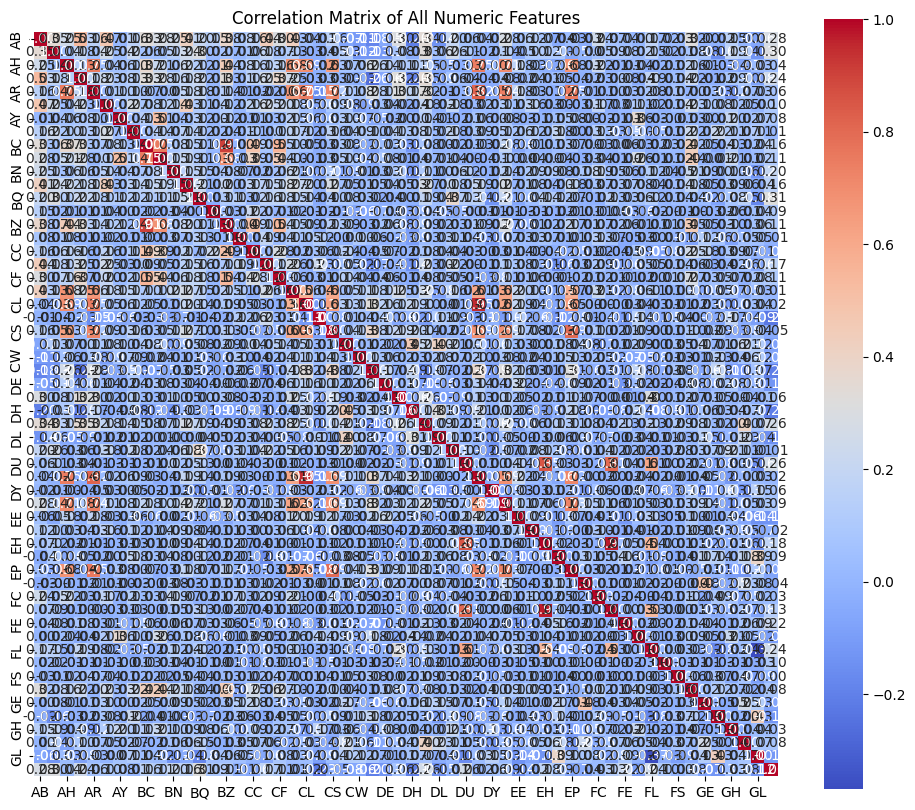

In [14]:
# Exclude non-numeric columns
numeric_cols = input_df.select_dtypes(include=np.number).columns.tolist()

# Calculate correlation matrix
corr_matrix = input_df[numeric_cols].corr()

# Plot correlation matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix of All Numeric Features')
plt.show()

# Data Cleaning

# Model

## Data splitting

In [7]:
from sklearn.model_selection import KFold
import tensorflow as tf
import tensorflow_decision_forests as tfdf

2023-07-08 09:51:31.411231: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-08 09:51:31.465873: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-08 09:51:31.931724: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-08 09:51:31.934377: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-08 09:51:34.457998: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [8]:
# Creates a GroupKFold with 5 splits
kf = KFold(n_splits=5, shuffle=True)

# Create list of ids for the creation of oof dataframe.
ID_LIST = input_df.index

# Create a dataframe of required size with zero values.
oof = pd.DataFrame(data=np.zeros((len(ID_LIST),1)), index=ID_LIST)

# Create an empty dictionary to store the models trained for each fold.
models = {}

# Create empty dict to save metrics for the models trained for each fold.
accuracy = {}
cross_entropy = {}

# Save the name of the label column to a variable.
label = "Class"

# Calculate the number of samples for each label.
neg, pos = np.bincount(input_df['Class'])

# Calculate total samples.
total = neg + pos

# Calculate the weight for each label.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

FEATURE_COLUMNS = [i for i in input_df.columns if i not in ["Id"]]

## Model training

In [9]:
# Loop through each fold
for i, (train_index, valid_index) in enumerate(kf.split(X=input_df)):
    print('##### Fold',i+1)

    # Fetch values corresponding to the index 
    train_df = input_df.iloc[train_index]
    valid_df = input_df.iloc[valid_index]
    valid_ids = valid_df.index.values
    
    # Select only feature columns for training.
    train_df = train_df[FEATURE_COLUMNS]
    valid_df = valid_df[FEATURE_COLUMNS]
    
    train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label=label)
    valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_df, label=label)

    # Define the model and metrics
    rf = tfdf.keras.RandomForestModel(
        num_trees=500,   # Number of trees to use in the ensemble
        max_depth=8,     # Max depth of the trees
        min_examples=5,  # Min samples per leaf
    )
    rf.compile(metrics=["accuracy", "binary_crossentropy"]) 
    
    # Model Training
    rf.fit(x=train_ds, class_weight=class_weight)
    models[f"fold_{i+1}"] = rf
    
    
    # Predict OOF value for validation data
    predict = rf.predict(x=valid_ds)
    
    # Store the predictions in oof dataframe
    oof.loc[valid_ids, 0] = predict.flatten() 
    
    # Evaluate and store the metrics in respective dicts
    evaluation = rf.evaluate(x=valid_ds,return_dict=True)
    accuracy[f"fold_{i+1}"] = evaluation["accuracy"]
    cross_entropy[f"fold_{i+1}"]= evaluation["binary_crossentropy"]

##### Fold 1


Use /tmp/tmpju01asey as temporary training directory
Reading training dataset...


2023-07-08 09:51:38.490957: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_50' with dtype double and shape [493]
	 [[{{node Placeholder/_50}}]]


Training dataset read in 0:00:10.280571. Found 493 examples.
Training model...
Model trained in 0:00:00.509451
Compiling model...


[INFO 23-07-08 09:51:48.9918 BST kernel.cc:1242] Loading model from path /tmp/tmpju01asey/model/ with prefix eae45ba3ca15472e
[INFO 23-07-08 09:51:49.0500 BST decision_forest.cc:660] Model loaded with 500 root(s), 21196 node(s), and 55 input feature(s).
[INFO 23-07-08 09:51:49.0501 BST abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-08 09:51:49.0501 BST kernel.cc:1074] Use fast generic engine
2023-07-08 09:51:49.105617: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_6' with dtype double and shape [493]
	 [[{{node Placeholder/_6}}]]


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.


2023-07-08 09:51:53.302140: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype double and shape [124]
	 [[{{node Placeholder/_5}}]]


1/1 [==============================] - 1s 1s/step - loss: 0.0000e+00 - accuracy: 0.9113 - binary_crossentropy: 0.2672
##### Fold 2


Use /tmp/tmp4g1a12el as temporary training directory
Reading training dataset...


2023-07-08 09:51:55.052758: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_36' with dtype double and shape [493]
	 [[{{node Placeholder/_36}}]]


Training dataset read in 0:00:01.765574. Found 493 examples.
Training model...
Model trained in 0:00:00.499327
Compiling model...


[INFO 23-07-08 09:51:57.0908 BST kernel.cc:1242] Loading model from path /tmp/tmp4g1a12el/model/ with prefix 844ea93212c64feb
[INFO 23-07-08 09:51:57.1630 BST decision_forest.cc:660] Model loaded with 500 root(s), 22132 node(s), and 55 input feature(s).
[INFO 23-07-08 09:51:57.1630 BST kernel.cc:1074] Use fast generic engine
2023-07-08 09:51:57.201211: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype double and shape [493]
	 [[{{node Placeholder/_8}}]]


Model compiled.


2023-07-08 09:51:58.111183: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_9' with dtype double and shape [124]
	 [[{{node Placeholder/_9}}]]


1/1 [==============================] - 1s 636ms/step - loss: 0.0000e+00 - accuracy: 0.9516 - binary_crossentropy: 0.2174
##### Fold 3


Use /tmp/tmp83l44493 as temporary training directory
Reading training dataset...


2023-07-08 09:51:59.399631: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_54' with dtype double and shape [494]
	 [[{{node Placeholder/_54}}]]


Training dataset read in 0:00:01.764583. Found 494 examples.
Training model...
Model trained in 0:00:00.425070
Compiling model...


[INFO 23-07-08 09:52:01.3692 BST kernel.cc:1242] Loading model from path /tmp/tmp83l44493/model/ with prefix d5341f44d5a741df
[INFO 23-07-08 09:52:01.4343 BST decision_forest.cc:660] Model loaded with 500 root(s), 21378 node(s), and 55 input feature(s).
[INFO 23-07-08 09:52:01.4344 BST abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-08 09:52:01.4344 BST kernel.cc:1074] Use fast generic engine
2023-07-08 09:52:01.471065: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_41' with dtype double and shape [494]
	 [[{{node Placeholder/_41}}]]


Model compiled.


2023-07-08 09:52:02.454905: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_41' with dtype double and shape [123]
	 [[{{node Placeholder/_41}}]]


1/1 [==============================] - 1s 625ms/step - loss: 0.0000e+00 - accuracy: 0.9106 - binary_crossentropy: 0.2549
##### Fold 4


Use /tmp/tmpkflfkwxb as temporary training directory
Reading training dataset...


2023-07-08 09:52:03.703244: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_53' with dtype double and shape [494]
	 [[{{node Placeholder/_53}}]]


Training dataset read in 0:00:01.628535. Found 494 examples.
Training model...
Model trained in 0:00:00.472720
Compiling model...


[INFO 23-07-08 09:52:05.5915 BST kernel.cc:1242] Loading model from path /tmp/tmpkflfkwxb/model/ with prefix 9654029f90cc49c4
[INFO 23-07-08 09:52:05.6515 BST decision_forest.cc:660] Model loaded with 500 root(s), 20622 node(s), and 55 input feature(s).
[INFO 23-07-08 09:52:05.6516 BST kernel.cc:1074] Use fast generic engine
2023-07-08 09:52:05.680090: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_6' with dtype double and shape [494]
	 [[{{node Placeholder/_6}}]]


Model compiled.


2023-07-08 09:52:06.597374: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_9' with dtype double and shape [123]
	 [[{{node Placeholder/_9}}]]


1/1 [==============================] - 1s 639ms/step - loss: 0.0000e+00 - accuracy: 0.8943 - binary_crossentropy: 0.3002
##### Fold 5


Use /tmp/tmpa2ubfj8e as temporary training directory
Reading training dataset...


2023-07-08 09:52:08.077968: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_62' with dtype double and shape [2]
	 [[{{node Placeholder/_62}}]]


Training dataset read in 0:00:01.950643. Found 494 examples.
Training model...
Model trained in 0:00:00.402242
Compiling model...


[INFO 23-07-08 09:52:10.2118 BST kernel.cc:1242] Loading model from path /tmp/tmpa2ubfj8e/model/ with prefix 12915fba806f4baa
[INFO 23-07-08 09:52:10.2769 BST decision_forest.cc:660] Model loaded with 500 root(s), 21536 node(s), and 55 input feature(s).
[INFO 23-07-08 09:52:10.2770 BST kernel.cc:1074] Use fast generic engine
2023-07-08 09:52:10.305322: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_53' with dtype double and shape [494]
	 [[{{node Placeholder/_53}}]]


Model compiled.


2023-07-08 09:52:11.232861: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_54' with dtype double and shape [123]
	 [[{{node Placeholder/_54}}]]


1/1 [==============================] - 0s 211ms/step


1/1 [==============================] - 1s 599ms/step - loss: 0.0000e+00 - accuracy: 0.9593 - binary_crossentropy: 0.2249


### check the model

In [10]:
for _model in models:
    inspector = models[_model].make_inspector()
    print(_model, inspector.evaluation())

fold_1 Evaluation(num_examples=493, accuracy=0.8528667435461482, loss=0.3710854464459711, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)
fold_2 Evaluation(num_examples=493, accuracy=0.870763285244046, loss=0.3755489601264486, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)
fold_3 Evaluation(num_examples=494, accuracy=0.8598166256949693, loss=0.3922796939075649, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)
fold_4 Evaluation(num_examples=494, accuracy=0.8564271191753962, loss=0.3841340207906238, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)
fold_5 Evaluation(num_examples=494, accuracy=0.8499792213066059, loss=0.3820638898518383, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)


# Prediction

## Preparing test data

In [11]:
test_ds_pd = test_df
test_df_columns = test_ds_pd.columns.tolist()
TEST_FEATURE_COLUMNS = [i for i in FEATURE_COLUMNS \
                        if i in test_df_columns and i != "Class"]
test_ds_pd = test_ds_pd[TEST_FEATURE_COLUMNS]
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_ds_pd)

In [12]:
## Making Prediction

In [13]:
# Ensemble Predictions
predictions = np.zeros((len(test_df), len(models)))
for i, model in enumerate(models.values()):
    predictions[:, i] = model.predict(test_ds).ravel()

# Averaging the predictions
average_predictions = predictions.mean(axis=1)
n_predictions = [[round(abs(i-1), 8), i] for i in average_predictions]
print(n_predictions)

2023-07-08 09:52:12.238570: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_15' with dtype double and shape [5]
	 [[{{node Placeholder/_15}}]]


1/1 [==============================] - 0s 194ms/step
[[0.68919973, 0.3108002722263336], [0.68919973, 0.3108002722263336], [0.68919973, 0.3108002722263336], [0.68919973, 0.3108002722263336], [0.68919973, 0.3108002722263336]]


# Submission

In [14]:
sample_submission[['class_0', 'class_1']] = n_predictions
sample_submission.to_csv('submission.csv', index=False)